In [21]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Анализируем данные о машинах car_info
🚗 Главное описание машин с информацией о поломках для обучения / прогноза - car_train.csv / car_test.csv.

Пояснение столбцов:

car_id - идентификатор машины
model / car_type / fuel_type- марка, класс и тип топлива машины
car_rating / riders - общий рейтинг  и общее число поездок к концу 2021-го кода.
year_to_start / year_to_work - года выпуска машины и начала работы в автопарке
main_city - город пребывания машины. (Москва или Питер)
target_reg - количество дней до поломки.
target_class - класс поломки (всего 9 видов)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
270,y-1123775i,Renault Kaptur,standart,petrol,6.24,2014,61969,2016,32.85,gear_stick
1451,h-2096845p,Smart Coupe,economy,petrol,4.76,2014,65374,2017,66.50,engine_check
1395,d-3934635Q,Kia Rio X-line,economy,petrol,6.76,2013,45317,2021,34.44,wheel_shake
2141,k46522161e,Smart ForTwo,economy,petrol,3.04,2013,44425,2020,65.36,engine_ignition
1174,B-9426058n,Hyundai Solaris,economy,petrol,5.56,2012,19082,2018,70.78,another_bug


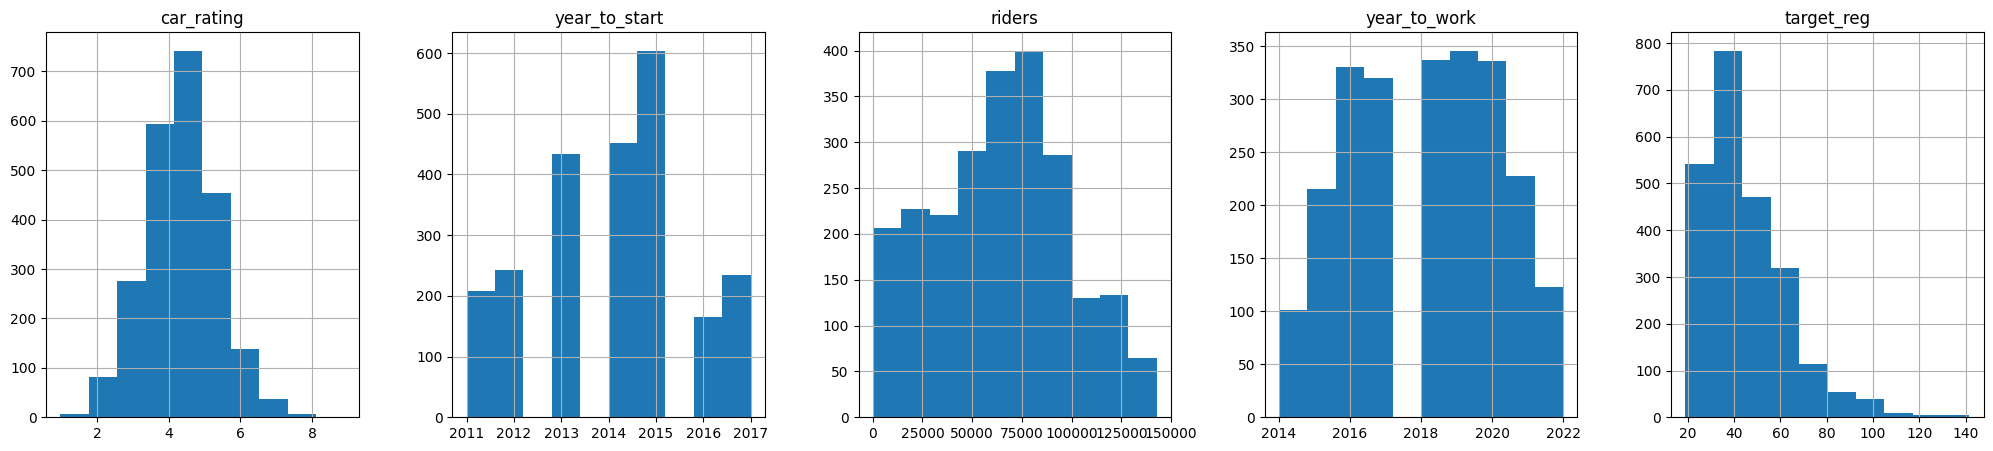

In [22]:
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv'
train = pd.read_csv(url)   # car_train - информация про машины с таргетом
train.hist(figsize=(25, 5), layout=(-1, 5));
train.sample(5)

In [23]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.946735
std,0.996954,1.685852,33755.012096,2.159484,17.579568
min,0.980000,2011.000000,23.000000,2014.000000,18.920000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.670000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.170000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.790000
max,8.900000,2017.000000,142862.000000,2022.000000,141.630000


In [24]:
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv'
test = pd.read_csv(url)
test.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
102,I-8201538D,Kia Rio X,economy,petrol,4.84,2013,38486,2019
890,h-4056890V,Kia Rio X-line,economy,petrol,5.04,2013,42773,2015
172,F94970727I,Fiat 500,business,petrol,3.28,2012,22674,2016
1672,R-1161362E,Tesla Model 3,premium,electro,4.84,2013,41467,2021
671,Q-4235244W,Kia Rio,economy,petrol,5.54,2011,4086,2018


# Classify features and types

In [25]:
features2drop = ['car_id']
targets = ['target_class', 'target_reg']
cat_features = ['car_type', 'fuel_type', 'model']

filtered_features = [col for col in train.columns if (col not in targets and col not in features2drop)]
num_features = [col for col in filtered_features if col not in cat_features]

print('cat_features:', len(cat_features), cat_features)
print('num_features:', len(num_features), num_features)
print('targets:', targets)

cat_features: 3 ['car_type', 'fuel_type', 'model']
num_features: 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets: ['target_class', 'target_reg']


# Train CatBoost and make a prediction on test

In [26]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features, n_estimators=100)

clf.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=150, plot=False)

y_pred = clf.predict(X_test)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred)}")

Learning rate set to 0.263488
0:	learn: 2.1785390	test: 2.1943955	best: 2.1943955 (0)	total: 42.4ms	remaining: 4.2s
99:	learn: 1.4720249	test: 2.3118861	best: 2.1851470 (5)	total: 5.21s	remaining: 0us

bestTest = 2.185146963
bestIteration = 5

Shrink model to first 6 iterations.

Accuracy: 0.11324786324786325


In [27]:
# save first baseline
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


# Добавим информацию про поездки из rides_info

🏇 Информация про поездки - rides_info.csv. Пояснение столбцов:

user_id / car_id / ride_id - идентификаторы водителя, машины, поездки соответственно
ride_date / rating - дата поездки и рейтинг, поставленный водителем
ride_duration / distance / ride_cost -  длительность (время),  пройденное расстояние, стоимость поездки
speed_avg / speed_max - средняя и максимальная скорости поездки соответственно
stop_times / refueling - количество остановок (паузы) и флаг - была ли дозаправка.
user_ride_quality - оценка манеры вождения в машины водителя, определенная скоринговой ML системой сервиса.
deviation_normal - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы).

In [28]:
try:
    rides_info = pd.read_csv('../data/rides_info.csv')
except FileNotFoundError:
    url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv'
    rides_info = pd.read_csv(url) # rides_info - информация про поездки
    rides_info.to_csv('../data/rides_info.csv')

rides_info.head()

,Unnamed: 0,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822


In [29]:
rides = rides_info.groupby('car_id', as_index=False).agg(speed_avg = ('speed_avg', 'mean'),
                                                         # rating_avg = ('rating', 'mean'),
                                                         distance_sum = ('distance', 'sum'),
                                                         rating_min = ('rating', 'min'),
                                                         speed_max = ('speed_max', 'max'),
                                                         user_ride_quality_median = ('user_ride_quality', 'median'),
                                                         # deviation_normal_sqr_sum = ('deviation_normal', lambda x: (x * x).sum()),
                                                         user_unique = ('user_id', lambda x: x.nunique())
                                                         )

In [30]:
rides.head(2)

,car_id,speed_avg,distance_sum,rating_min,speed_max,user_ride_quality_median,user_unique
0,A-1049127W,49.459770,1.125753e+07,0.1,179.729652,-0.288229,172
1,A-1079539w,49.591954,1.912765e+07,0.1,184.505566,2.508746,173


In [31]:
def add_features(df):
    if 'speed_avg' not in df.columns:
        return df.merge(rides, on = 'car_id', how = 'left')
    return df

In [32]:
train = add_features(train)
test = add_features(test)

In [33]:
train.sample(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,speed_avg,distance_sum,rating_min,speed_max,user_ride_quality_median,user_unique
672,l-1337696j,Kia Sportage,standart,petrol,4.74,2011,4267,2018,58.97,another_bug,43.206897,1.194086e+07,0.1,178.000000,4.410259,174
136,W14795073t,Skoda Rapid,economy,petrol,4.40,2016,115249,2016,54.93,engine_ignition,48.281609,1.446494e+07,0.1,173.469291,3.351716,172
578,x58256990o,VW Tiguan,economy,petrol,4.22,2013,46797,2021,66.37,engine_check,44.321839,1.605829e+07,0.1,155.000000,9.586035,170


In [34]:
train.to_csv('../data/quickstart_train.csv', index=False)

# Update feature types

In [35]:
filtered_features = [col for col in train.columns if (col not in targets and col not in features2drop)]
num_features = [col for col in filtered_features if col not in cat_features]

print("num_features:", len(num_features), num_features)
print("cat_features:", len(cat_features), cat_features)

num_features: 10 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'speed_avg', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_unique']
cat_features: 3 ['car_type', 'fuel_type', 'model']


In [36]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = CatBoostClassifier(cat_features=cat_features, n_estimators=150)

clf.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=25, plot=True)

# model inference
y_pred = clf.predict(X_test)
print(f"\nAccuracy:", accuracy_score(y_test, y_pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.22568
0:	learn: 1.6152296	test: 1.6272818	best: 1.6272818 (0)	total: 53.9ms	remaining: 8.03s
25:	learn: 0.6031375	test: 0.7444473	best: 0.7443072 (24)	total: 1.51s	remaining: 7.18s
50:	learn: 0.4826921	test: 0.6968853	best: 0.6968853 (50)	total: 2.95s	remaining: 5.72s
75:	learn: 0.4059397	test: 0.6949243	best: 0.6894705 (66)	total: 4.42s	remaining: 4.3s
100:	learn: 0.3521004	test: 0.6931743	best: 0.6894705 (66)	total: 5.91s	remaining: 2.87s
125:	learn: 0.3097687	test: 0.6994780	best: 0.6894705 (66)	total: 7.34s	remaining: 1.4s
149:	learn: 0.2770299	test: 0.7043549	best: 0.6894705 (66)	total: 8.77s	remaining: 0us

bestTest = 0.6894705365
bestIteration = 66

Shrink model to first 67 iterations.

Accuracy: 0.7136752136752137


In [37]:
fi = clf.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,37.614472
1,speed_avg,29.077088
2,rating_min,13.849362
3,car_type,3.855765
4,user_unique,3.587689
5,model,3.178964
6,user_ride_quality_median,2.068787
7,car_rating,2.057513
8,distance_sum,1.788548
9,riders,1.311904


In [38]:
# save updated baseline
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v2.csv', index=False)
print("CSV saved!")

CSV saved!


In [39]:
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv'
drivers = pd.read_csv(url)  # driver_info - информация про водителей
drivers.head()

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,19.0,l17437965W,1,2019-4-2
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19
2,59,7.8,947,4.0,g11098715c,0,2021-1-15
3,37,7.0,18,4.0,U12618125q,0,2019-11-20
4,39,8.2,428,7.0,A14375829B,0,2019-7-23


In [40]:
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv'
fix_info = pd.read_csv(url)  # fix_info - информация про ремонт машин
fix_info.head()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,P17494612l,RJ,2020-6-20 2:14,reparking,8.0,49
1,N-1530212S,LM,2020-2-9 20:25,repair,10.0,48
2,B-1154399t,ND,2019-8-24 7:1,reparking,1.0,27
3,y13744087j,PG,2019-8-10 9:29,reparking,1.0,28
4,F12725233R,YC,2020-11-12 5:22,refuel_check,8.0,47
